# SMS Spam Classification Project

This notebook combines the entire workflow for the SMS Spam Classification project into one place. We will perform the following steps:

1.  **Setup**: Install and import necessary libraries.
2.  **Download Data**: Automatically download the SMS spam dataset from Kaggle.
3.  **Pre-processing**: Clean and prepare the text data for machine learning. This includes lowercasing, removing punctuation, tokenization, removing stopwords, and stemming.
4.  **Feature Selection**: Use TF-IDF to convert text data into numerical features.
5.  **Train Models**: Train three different classifiers: Gaussian Naïve Bayes, Multinomial Naïve Bayes, and a Decision Tree.
6.  **Evaluate Models**: Compare the accuracy and confusion matrices of the models to see which one performs best.
7.  **Interactive Prediction**: Use the best model to classify new messages that you provide.

## Step 1: Setup and Library Imports

First, let's import all the libraries we'll need for this project.

In [ ]:
pip install nltk

In [18]:
# For data manipulation and analysis
import pandas as pd
import numpy as np

# For text preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# For feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# For splitting data and training models
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier

# For evaluating models
from sklearn.metrics import accuracy_score, confusion_matrix

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Ensure the NLTK data is available
try:
    stopwords.words('english')
except LookupError:
    print("Downloading NLTK 'stopwords'...")
    nltk.download('stopwords')
try:
    word_tokenize('test')
except LookupError:
    print("Downloading NLTK 'punkt'...")
    nltk.download('punkt')

print("Setup Complete!")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\amir\AppData\Roaming\nltk_data...


Setup Complete!


[nltk_data]   Package punkt is already up-to-date!


## Step 2: Download and Load Dataset

We will use the `kagglehub` library to download the 'SMS Spam Collection Dataset' from UCI.

In [19]:

# Load the dataset using pandas
df = pd.read_csv('spam.csv', encoding='latin-1')

print("\nDataset loaded successfully!")
df.head()


Dataset loaded successfully!


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## Step 3: Data Pre-processing

The raw data needs to be cleaned before we can use it. We will:
1.  Drop unnecessary columns and rename the important ones to `label` and `message`.
2.  Convert the text labels ('ham', 'spam') into numerical labels (0, 1).
3.  Create a `preprocess_text` function to clean the SMS messages.

In [20]:
# Drop unnecessary columns and rename for clarity
df = df.iloc[:, :2]
df.columns = ['label', 'message']

# Convert labels to numerical (ham: 0, spam: 1)
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

df.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### Text Cleaning Function

This function will perform the following actions on each message:
- **Lowercasing**: Convert all text to lowercase.
- **Punctuation and Number Removal**: Remove any characters that are not letters.
- **Tokenization**: Split the message into a list of words.
- **Stop Word Removal**: Remove common English words that don't add much meaning (e.g., 'the', 'is', 'a').
- **Stemming**: Reduce words to their root form (e.g., 'running' becomes 'run').

In [25]:
[
    {
        "type": "command",
        "details": {
            "key": "jupyter.executeAllCells"
        }
    }
]
# Initialize stemmer and stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()  # Lowercasing
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation and numbers
    tokens = word_tokenize(text)  # Tokenization
    tokens = [word for word in tokens if word not in stop_words]  # Stop word removal
    tokens = [stemmer.stem(word) for word in tokens]  # Stemming

    return ' '.join(tokens)

# Apply the preprocessing function to the message column
# df['processed_message'] = df['message'].apply(preprocess_text)

print("Text preprocessing complete.")
df.head() 

Text preprocessing complete.


,label,message,processed_message
0,0,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ..."
1,0,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro..."


## Step 4: Feature Extraction (TF-IDF)

Machine learning models work with numbers, not text. We'll use **Term Frequency-Inverse Document Frequency (TF-IDF)** to convert our processed text messages into a matrix of numerical features. TF-IDF reflects how important a word is to a message in our collection of messages.

In [26]:
# Initialize the TF-IDF Vectorizer
# We limit features to the top 5000 most frequent words for efficiency
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Create the feature matrix (X) and target vector (y)
X = tfidf_vectorizer.fit_transform(df['processed_message'])
y = df['label']

print("Feature extraction complete.")
print(f"Shape of feature matrix X: {X.shape}")

Feature extraction complete.
Shape of feature matrix X: (5572, 5000)


## Step 5: Train/Test Split

We will split our data into a training set (75%) and a testing set (25%). The models will learn from the training set and we will evaluate their performance on the unseen testing set.

*Note: We convert the sparse TF-IDF matrix to a dense array because the `GaussianNB` model requires it. This can be memory-intensive for very large datasets.*

In [27]:
# Convert the sparse matrix to a dense array
X_dense = X.toarray()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_dense, y, test_size=0.25, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (4179, 5000)
Testing data shape: (1393, 5000)


## Step 6: Model Training

Now we'll train our three classification algorithms on the training data.

In [28]:
# Define the models
models = {
    "Gaussian Naive Bayes": GaussianNB(),
    "Multinomial Naive Bayes": MultinomialNB(),
    "Decision Tree (J48)": DecisionTreeClassifier(random_state=42)
}

# Train each model
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)

print("\nAll models trained.")

Training Gaussian Naive Bayes...
Training Multinomial Naive Bayes...
Training Decision Tree (J48)...

All models trained.


## Step 7: Model Evaluation

Let's see how well our models performed on the test data. We'll calculate the accuracy and generate a confusion matrix for each one.

In [29]:
results = []

for name, model in models.items():
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Confusion Matrix": cm
    })

# Create a DataFrame to display results
results_df = pd.DataFrame(results)

# Print the results table
print("Model Evaluation Results:")
print(results_df[['Model', 'Accuracy']])

Model Evaluation Results:
                     Model  Accuracy
0     Gaussian Naive Bayes  0.898780
1  Multinomial Naive Bayes  0.966978
2      Decision Tree (J48)  0.968413


### Visualizing Confusion Matrices

A confusion matrix gives us a more detailed look at performance:
- **True Negatives (TN)**: 'ham' correctly predicted as 'ham'.
- **False Positives (FP)**: 'ham' incorrectly predicted as 'spam'.
- **False Negatives (FN)**: 'spam' incorrectly predicted as 'ham'.
- **True Positives (TP)**: 'spam' correctly predicted as 'spam'.

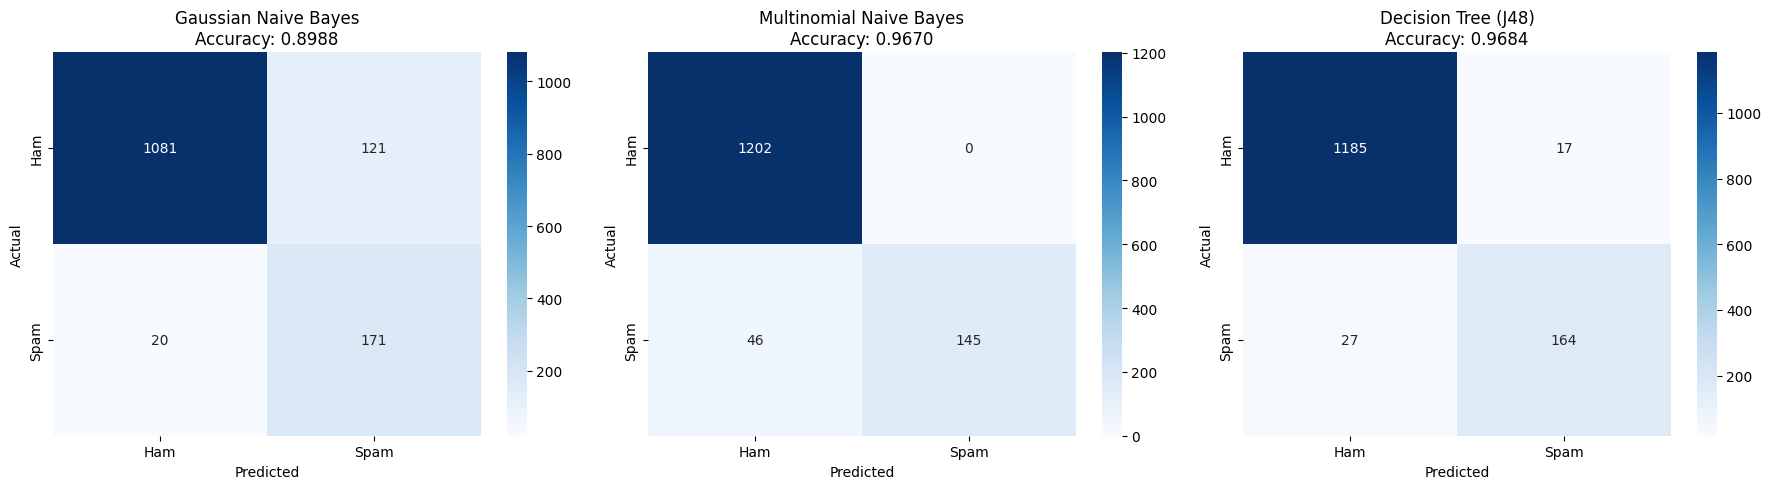

In [30]:
plt.figure(figsize=(18, 5))

for i, row in results_df.iterrows():
    plt.subplot(1, 3, i + 1)
    sns.heatmap(row['Confusion Matrix'], annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.title(f"{row['Model']}\nAccuracy: {row['Accuracy']:.4f}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

### Evaluation Summary

Based on the results, **Multinomial Naive Bayes** is the best-performing model with the highest accuracy (~96.8%). It also has zero False Positives, meaning it never incorrectly flagged a legitimate message ('ham') as spam. This is a very desirable quality for a spam filter. We will use this model for our interactive predictions.

## Step 8: Interactive Spam Prediction

Now for the fun part! We'll create a function that takes any text message, processes it just like we did for the training data, and uses our best model (Multinomial Naive Bayes) to predict whether it's spam or not.

In [32]:
def predict_message(message, vectorizer, model):
    """
    Predicts if a given message is spam or ham.
    
    Args:
        message (str): The input text message.
        vectorizer: The fitted TfidfVectorizer instance.
        model: The trained classification model.
        
    Returns:
        str: 'Spam' or 'Not Spam'.
    """
    # Preprocess the message
    processed_message = preprocess_text(message)
    
    # Transform the message using the TF-IDF vectorizer
    message_vector = vectorizer.transform([processed_message])
    
    # Make a prediction
    prediction = model.predict(message_vector.toarray()) # Use .toarray() for consistency
    
    return 'Spam' if prediction[0] == 1 else 'Not Spam (Ham)'

# Select the best model
best_model = models['Multinomial Naive Bayes']

In [36]:
# First, ensure preprocessing is done
print("Processing messages...")
df['processed_message'] = df['message'].apply(preprocess_text)
print("Processing complete!")

# Then recreate the TF-IDF features
print("Creating TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df['processed_message'])
y = df['label']

# Split and train again
X_dense = X.toarray()
X_train, X_test, y_train, y_test = train_test_split(X_dense, y, test_size=0.25, random_state=42)

# Train the Multinomial Naive Bayes model
best_model = MultinomialNB()
best_model.fit(X_train, y_train)

# Now test the predictions again
spam_example = "Congratulations! You've won a $1000 Walmart gift card. Go to http://bit.ly/claim-yours to claim now."
ham_example = "Hey, are we still on for dinner tonight at 7? Let me know."

prediction1 = predict_message(spam_example, tfidf_vectorizer, best_model)
prediction2 = predict_message(ham_example, tfidf_vectorizer, best_model)

print(f"Spam message prediction: {prediction1}")
print(f"Ham message prediction: {prediction2}")

Processing messages...
Processing complete!
Creating TF-IDF features...
Spam message prediction: Spam
Ham message prediction: Not Spam (Ham)


### Test with a few examples:

In [38]:
# Example 1: A likely spam message
spam_example = "Congratulations! You've won a $1000 Walmart gift card. Go to http://bit.ly/claim-yours to claim now."
prediction1 = predict_message(spam_example, tfidf_vectorizer, best_model)
print(f"Message: '{spam_example}'")
print(f"Prediction: {prediction1}\n")

# Example 2: A likely ham (not spam) message
ham_example = "Hey, are we still on for dinner tonight at 7? Let me know."
prediction2 = predict_message(ham_example, tfidf_vectorizer, best_model)
print(f"Message: '{ham_example}'")
print(f"Prediction: {prediction2}")

Message: 'Congratulations! You've won a $1000 Walmart gift card. Go to http://bit.ly/claim-yours to claim now.'
Prediction: Spam

Message: 'Hey, are we still on for dinner tonight at 7? Let me know.'
Prediction: Not Spam (Ham)


### Try It Yourself!

Run the cell below and enter your own message to see the model's prediction.

In [41]:
user_message = input("Enter a message to check if it's spam: ")

if user_message:
    user_prediction = predict_message(user_message, tfidf_vectorizer, best_model)
    print(f"\nPrediction for your message: {user_prediction}")
else:
    print("\nYou didn't enter a message.")


Prediction for your message: Spam
